In [1]:
%pwd

'/Users/ryandevera/data-science/umn_environments/Deeplifting/deeplifting/notebooks'

In [2]:
%cd ../..

/Users/ryandevera/data-science/umn_environments/Deeplifting


In [3]:
%ls

LJ_data/                        high-dimension-search-results/
LJ_data.tar                     images/
README.md                       jobs/
__pycache__/                    low-dimension-search-results/
algorithm_compare_results/      models/
data/                           paper-images/
data-queue/                     requirements.txt
data-queue-2023-09-24/          results/
data-queue-2023-09-27/          search_results/
deeplifting/                    tasks.py
deeplifting.png                 test-low-dimension-results.png
high-dimension-paper-results/


In [4]:
import glob as glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import tqdm

In [5]:
minima = [
    -1.0,
    -3.0,
    -6.0,
    -9.103852,
    -12.712062,
    -16.505384,
    -19.821489,
    -24.113360,
    -28.422532,
    -32.765970,
    -37.967600,
    -44.326801,
    -47.845157,
    -52.322627,
    -56.815742,
    -61.317995,
    -66.530949,
    -72.659782,
    -77.1777043,
]

dimensions = 18
k = int(dimensions / 3)
print(minima[k - 2])

-12.712062


# Algorithm Comparison Results

In [6]:
# Algorithm keep columns
algorithm_columns = [
    'problem_name',
    'algorithm',
    'dimensions',
    'hits',
    'time',
    'f',
]

# Results from comparison algorithms
file_directory = './data-queue-2023-09-24/lennard-jones/*/*'
files = glob.glob(file_directory)
print(files)
algorithm_df = pd.read_parquet(files)

# algorithm_df = algorithm_df[algorithm_columns]
algorithm_df.head()

['./data-queue-2023-09-24/lennard-jones/2023-09-27-19-lennard_jones_6d/high-dimensional.parquet', './data-queue-2023-09-24/lennard-jones/2023-09-27-19-lennard_jones_9d/high-dimensional.parquet', './data-queue-2023-09-24/lennard-jones/2023-09-27-19-lennard_jones_39d/high-dimensional.parquet', './data-queue-2023-09-24/lennard-jones/2023-09-27-19-lennard_jones_15d/high-dimensional.parquet', './data-queue-2023-09-24/lennard-jones/2023-09-27-19-lennard_jones_30d/high-dimensional.parquet', './data-queue-2023-09-24/lennard-jones/2023-09-27-19-lennard_jones_12d/high-dimensional.parquet']


,x1,x2,x3,x4,x5,x6,f,algorithm,time,problem_name,hits,dimensions,global_minimum
0,0.199278,-2.062641,3.979216,0.080254,-1.298956,3.344694,-1.000000,IPOPT,7.213272,lennard_jones_6d,1,6,-1.0
1,-0.675364,0.197436,-1.715730,-0.758771,-0.330333,-0.870447,-1.000000,IPOPT,0.243690,lennard_jones_6d,1,6,-1.0
2,-0.512564,-2.637491,-0.234690,-0.514059,-1.764502,-0.722428,-1.000000,IPOPT,0.134558,lennard_jones_6d,1,6,-1.0
3,1.167353,1.966790,-2.353343,3.387183,3.850913,-1.856773,-0.003010,IPOPT,3.223256,lennard_jones_6d,0,6,-1.0
4,3.592226,0.395244,3.551234,1.740235,1.555331,-2.164514,-0.000038,IPOPT,1.855879,lennard_jones_6d,0,6,-1.0


In [7]:
algorithm_df.loc[algorithm_df['dimensions'] == 30]

,x1,x2,x3,x4,x5,x6,f,algorithm,time,problem_name,hits,dimensions,global_minimum
160,0.014655,1.185845,0.667474,0.395360,0.400464,1.171047,-28.422532,IPOPT,14.414555,lennard_jones_30d,1,30,-28.422532
161,-0.023598,-1.365037,-0.180617,-0.709143,-0.764014,-0.570490,-25.504008,IPOPT,13.503557,lennard_jones_30d,0,30,-28.422532
162,-0.420450,-0.479359,-0.177342,-0.576263,-0.332819,-1.140750,-27.446829,IPOPT,13.699076,lennard_jones_30d,0,30,-28.422532
163,0.051998,-0.442943,-0.328412,-0.349672,0.410630,-0.585657,-28.422532,IPOPT,1.137159,lennard_jones_30d,1,30,-28.422532
164,1.424931,0.467431,0.029433,1.182457,0.479089,-0.938447,-27.545207,IPOPT,13.284158,lennard_jones_30d,0,30,-28.422532
165,-0.593776,-0.350773,-1.200221,0.887901,-0.260658,-0.544374,-27.446829,IPOPT,13.265356,lennard_jones_30d,0,30,-28.422532
166,1.603740,-0.137736,0.053167,0.722420,-0.515654,0.240087,-27.114910,IPOPT,13.152801,lennard_jones_30d,0,30,-28.422532
167,0.115973,-0.014985,-0.247585,0.865566,0.443677,0.228445,-26.442885,IPOPT,13.287054,lennard_jones_30d,0,30,-28.422532
168,0.952810,0.100135,0.909428,0.390387,-0.787319,-0.756078,-26.442885,IPOPT,13.198151,lennard_jones_30d,0,30,-28.422532
169,-0.030053,-0.852286,0.926407,-0.649719,-0.016745,0.196270,-26.483909,IPOPT,13.187844,lennard_jones_30d,0,30,-28.422532


In [8]:
# Let's get the algorithm compare results!
algorithm_results_df = algorithm_df.groupby(
    ['problem_name', 'algorithm', 'dimensions']
).agg({'hits': ['count', 'mean'], 'time': 'mean'})
algorithm_results_df.columns = [
    '-'.join(column) for column in algorithm_results_df.columns
]
algorithm_results_df = algorithm_results_df.reset_index()

# Need to verify that all problems have the same number of trials in the end
algorithm_results_df = algorithm_results_df.drop(columns=['hits-count'])
algorithm_results_df.pivot_table(
    index='dimensions', columns='algorithm', values='hits-mean'
)

algorithm,Basinhopping,Differential Evolution,Dual Annealing,IPOPT
dimensions,,,,
6,1.0,1.0,1.0,0.4
9,0.9,1.0,1.0,0.8
12,0.9,1.0,1.0,1.0
15,0.9,1.0,0.9,1.0
30,0.2,0.1,0.0,0.2
39,0.1,0.1,0.0,0.0


In [9]:
# Can we visualize the problem?

In [10]:
import torch


def pairwise_distances(positions: torch.Tensor) -> torch.Tensor:
    # Assume positions has shape [B, 3N] where B is the batch size and N is the number of atoms
    # Reshaping to get individual atoms' positions of shape [B, N, 3]
    positions = positions.view(positions.shape[0], -1, 3)
    # Compute the pairwise differences
    # Subtracting [B, 1, N, 3] from [B, N, 1, 3] gives [B, N, N, 3]
    deltas = positions.unsqueeze(2) - positions.unsqueeze(1)
    # Norm the differences gives [B, N, N]
    distances = torch.norm(deltas, dim=-1)
    return distances


def cluster_potential(positions: torch.Tensor) -> torch.Tensor:
    # Compute the pairwise distances of atoms
    distances = pairwise_distances(positions)

    # Compute the pairwise cost (1 / dist)^12 - (1 / dist)^ 6
    pairwise_cost = (1 / distances).pow(12) - (1 / distances).pow(6.0)

    # Get the upper triangle matrix (ignoring the diagonal)
    ut_pairwise_cost = torch.triu(pairwise_cost, diagonal=1)

    # 4 * Summutation of the upper triangle of pairwise costs gives potential
    potential = 4 * ut_pairwise_cost.sum(dim=(1, 2))
    return potential

In [11]:
import requests
import tarfile

# Url of tar containing known global minima
url = 'http://doye.chem.ox.ac.uk/jon/structures/LJ/LJ.tar'
# Where to save the tar -- modify as desired
target_path = 'LJ_data.tar'

# Download
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(target_path, 'wb') as f:
        f.write(response.raw.read())

# Open file
file = tarfile.open(target_path)

#  By default save the data to the 'LJ_data' folder in the local directory
data_path = f'./{target_path.replace(".tar", "")}'
file.extractall(data_path)

file.close()

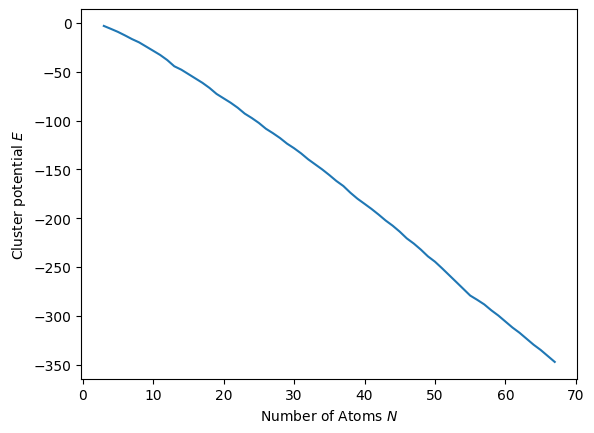

Potential of N=67 is computed as -347.25201416015625 vs. published value -347.252007


In [12]:
import matplotlib.pyplot as plt
import pandas

# Lists to track atom counts and potentials
atom_counts = []
global_potentials = []

# Iterate from 3 to 67 atoms -- the number visited in the paper
for n_atoms in range(3, 68):
    # File path is simply the nuimber of atoms
    file_path = f'{data_path}/{n_atoms}'
    # Get the positions as a dataframe
    dataframe = pandas.read_csv(file_path, header=None, delim_whitespace=True)
    # Make a positions tensor -- note that we add an initial dimension as the objective function is vectorised
    positions = torch.Tensor(dataframe.to_numpy()).unsqueeze(0)
    # Get the potential
    potential = cluster_potential(positions)

    # Update lists of atom counts and potentials
    atom_counts.append(n_atoms)
    global_potentials.append(potential.item())

# Simple plot
plt.plot(atom_counts, global_potentials)
plt.xlabel('Number of Atoms $N$')
plt.ylabel('Cluster potential $E$')
plt.show()

# Sanity check on the last one
print(
    f'Potential of N={n_atoms} is computed as {potential.item()} vs. published value -347.252007'
)

In [13]:
from evotorch import Problem
from evotorch.algorithms import SNES

snes_potentials = []

for n_atoms in range(3, 20):
    print(f'Solving case N={n_atoms} with SNES')

    # Set up the problem in vectorised mode
    problem = Problem(
        'min',
        cluster_potential,
        vectorized=True,
        device='cuda:0' if torch.cuda.is_available() else 'cpu',
        dtype=torch.float64,  # Higher precision could be helpful
        solution_length=3 * n_atoms,
        initial_bounds=(-1e-12, 1e-12),  # Taken directly from [2]
        store_solution_stats=True,  # Make sure the problem tracks the best discovered solution, even on GPU
    )

    searcher = SNES(
        problem,
        stdev_init=0.01,  # Taken directly from [2]
        popsize=10 * n_atoms,  # Significantly higher than [2]
        center_learning_rate=0.5,  # Halving value from [2] slows learning
        stdev_learning_rate=0.5,  # Halving value from [2] slows learning
        scale_learning_rate=True,  # Boolean flag means modifying the above learning rates rescales the default
    )
    searcher.run(
        1000 * problem.solution_length
    )  # 2x value used in [2], adjusted for half learning rates

    # Best solution found
    best_potential = problem.status['best_eval']
    # Center is also a good estimate
    center_potential = cluster_potential(searcher.status['center'].cpu().unsqueeze(0))[
        0
    ].item()
    if center_potential < best_potential:
        best_potential = center_potential

    print(f'Found potential {best_potential}')

    snes_potentials.append(best_potential)

Solving case N=3 with SNES
[2023-09-29 08:18:03] INFO     <46714> evotorch.core: Instance of `Problem` (id:5356411488) -- The `dtype` for the problem's decision variables is set as torch.float64
[2023-09-29 08:18:03] INFO     <46714> evotorch.core: Instance of `Problem` (id:5356411488) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float64
[2023-09-29 08:18:03] INFO     <46714> evotorch.core: Instance of `Problem` (id:5356411488) -- The `device` of the problem is set as cpu
[2023-09-29 08:18:03] INFO     <46714> evotorch.core: Instance of `Problem` (id:5356411488) -- The number of actors that will be allocated for parallelized evaluation is 0


/Users/ryandevera/.virtualenvs/deeplifing/lib/python3.9/site-packages/evotorch/logging.py:52: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune
/Users/ryandevera/.virtualenvs/deeplifing/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)


Found potential -3.000000000000001
Solving case N=4 with SNES
[2023-09-29 08:18:14] INFO     <46714> evotorch.core: Instance of `Problem` (id:5439176080) -- The `dtype` for the problem's decision variables is set as torch.float64
[2023-09-29 08:18:14] INFO     <46714> evotorch.core: Instance of `Problem` (id:5439176080) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float64
[2023-09-29 08:18:14] INFO     <46714> evotorch.core: Instance of `Problem` (id:5439176080) -- The `device` of the problem is set as cpu
[2023-09-29 08:18:14] INFO     <46714> evotorch.core: Instance of `Problem` (id:5439176080) -- The number of actors that will be allocated for parallelized evaluation is 0
Found potential -6.000000000000002
Solving case N=5 with SNES
[2023-09-29 08:18:30] INFO     <46714> evotorch.core: Instance of `Problem` (id:5439174304) -- The `dtype` for the problem's decision variables is set as torch.float64
[2023-09-29 08:18:30] INFO     <46714> evotorch.co

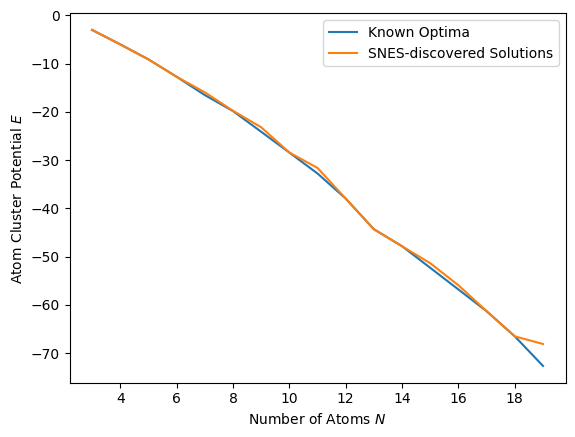

In [14]:
# Simple plot
plt.plot(
    atom_counts[0 : len(snes_potentials)],
    global_potentials[0 : len(snes_potentials)],
    label='Known Optima',
)
plt.plot(
    atom_counts[0 : len(snes_potentials)],
    snes_potentials[0 : len(snes_potentials)],
    label='SNES-discovered Solutions',
)
plt.legend()
plt.xlabel('Number of Atoms $N$')
plt.ylabel('Atom Cluster Potential $E$')
plt.show()

In [71]:
torch.random.manual_seed(0)
N = 4
x = torch.randn(3 * N).reshape(1, -1)
x.shape

torch.Size([1, 12])

In [72]:
positions = x.view(x.shape[0], -1, 3)
positions

tensor([[[ 1.5410, -0.2934, -2.1788],
         [ 0.5684, -1.0845, -1.3986],
         [ 0.4033,  0.8380, -0.7193],
         [-0.4033, -0.5966,  0.1820]]])

In [73]:
deltas = positions.unsqueeze(2) - positions.unsqueeze(1)
deltas

tensor([[[[ 0.0000,  0.0000,  0.0000],
          [ 0.9726,  0.7911, -0.7802],
          [ 1.1376, -1.1315, -1.4595],
          [ 1.9443,  0.3032, -2.3608]],

         [[-0.9726, -0.7911,  0.7802],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.1651, -1.9225, -0.6793],
          [ 0.9718, -0.4879, -1.5806]],

         [[-1.1376,  1.1315,  1.4595],
          [-0.1651,  1.9225,  0.6793],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.8067,  1.4347, -0.9013]],

         [[-1.9443, -0.3032,  2.3608],
          [-0.9718,  0.4879,  1.5806],
          [-0.8067, -1.4347,  0.9013],
          [ 0.0000,  0.0000,  0.0000]]]])

In [98]:
distances = torch.norm(deltas, dim=-1) ** 2
distances

tensor([[[0.0000, 2.1804, 4.7047, 9.4459],
         [2.1804, 0.0000, 4.1849, 3.6808],
         [4.7047, 4.1849, 0.0000, 3.5213],
         [9.4459, 3.6808, 3.5213, 0.0000]]])

In [99]:
dist_list = []
energies = []
N = 12
k = int(N / 3)
s = 0.0

x = x.flatten()
for i in range(k - 1):
    for j in range(i + 1, k):
        a = 3 * i
        b = 3 * j
        xd = x[a] - x[b]
        yd = x[a + 1] - x[b + 1]
        zd = x[a + 2] - x[b + 2]
        ed = xd * xd + yd * yd + zd * zd
        ud = ed * ed * ed
        dist_list.append(ed)
        energies.append(1 / ed**6 - 2 / ed**3)

In [100]:
np.array(energies).sum()

-0.31720075

In [101]:
distances = torch.triu(distances, diagonal=1)

In [102]:
mask = distances > 0
distances[mask]

tensor([2.1804, 4.7047, 9.4459, 4.1849, 3.6808, 3.5213])

In [103]:
(1 / distances[mask] ** 6 - 2 / distances[mask] ** 3).sum()

tensor(-0.3172)

In [104]:
dist_list

[tensor(2.1804),
 tensor(4.7047),
 tensor(9.4459),
 tensor(4.1849),
 tensor(3.6808),
 tensor(3.5213)]